In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm.auto import tqdm


/Users/sterling/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from astropy.convolution import convolve, Gaussian1DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats

def rolling_stats(eval_locs,width,xdata,ydata,min_data_size=10,sigma_clip=4):
    means, stds = [],[]
    for eval_loc in eval_locs:
        s = (xdata > eval_loc-width/2) & (xdata < eval_loc+width/2)
        if s.sum() > min_data_size:
            mean,median,std = sigma_clipped_stats(ydata[s],sigma=sigma_clip)
            means.append(mean)
            stds.append(std)
        else:
            means.append(np.nan)
            stds.append(np.nan)
    return np.array(means),np.array(stds)

In [3]:
gaussian = lambda x,mu,sigma,A: A*np.exp(-((x-mu)**2)/(2*sigma**2))

shape = 256
pixels = np.arange(0,shape)
star_raw_FWHM = 0.2
FWHM = 2
kernel = Gaussian1DKernel(FWHM)

bkg_stds = np.array([])
bkg_means = np.array([])
true_fluxes = np.array([])
fitted_fluxes = np.array([])
images = np.array([])
fitted_maxes = np.array([])
unc_maxes = np.array([])

Nsims = 5000
galaxy_widths = np.random.uniform(5,20,Nsims)
galaxy_fluxes  = 10**np.random.uniform(0,2,Nsims)
noise_levels = np.ones(Nsims) * 0 #np.random.uniform(0.1,1,Nsims)
Nstarss = np.random.uniform(10,3000,Nsims).astype(int)
star_lum_betas = np.ones(Nsims)*10 #np.random.uniform(1,20,Nsims).astype(float)


In [531]:
for galaxy_width,galaxy_flux,noise_level,Nstars,star_lum_beta in tqdm(zip(galaxy_widths,galaxy_fluxes,noise_levels,Nstarss,star_lum_betas),total=Nsims):
    '''simulate crowdy field with a galaxy and foreground stars, estimate the background level, and fit the galaxy.
    The following items are randomly varied:
    - galaxy width
    - galaxy flux (max value)
    - noise level
    - number of stars
    - star max luminosity distribution (scale parameter for exponential distribution)
    - star locations
    '''
    
    # create a galaxy
    galaxy = gaussian(pixels, shape/2, galaxy_width, galaxy_flux)
    true_flux = galaxy.sum()

    # add Gaussian noise in each pixel
    noise = np.random.normal(0, noise_level, shape)

    # add some stars
    star_fluxes = np.random.exponential(star_lum_beta,Nstars)
    star_locs = np.random.uniform(0,shape,Nstars)
    stars = np.array([gaussian(pixels, loc, star_raw_FWHM, flux) for loc,flux in zip(star_locs,star_fluxes)])

    # convolve stars with Gaussian kernel and project everything onto the same axis
    background = noise + convolve(stars.sum(axis=0),kernel=kernel)
    bkg_mean = background.mean()
    bkg_std = background.std()

    # fit Gaussian to the galaxy
    fixed_gaussian = lambda x,A: gaussian(x,shape/2,galaxy_width,A)
    popt, pcov = curve_fit(fixed_gaussian, pixels, galaxy+background-bkg_mean, p0=[10])
    unc = np.sqrt(np.diag(pcov))[0]
    bestfit_galaxy = fixed_gaussian(pixels, *popt)
    bestfit_flux = bestfit_galaxy.sum()
    
    # save data
    bkg_stds = np.append(bkg_stds,bkg_std)
    bkg_means = np.append(bkg_means,bkg_mean)
    true_fluxes = np.append(true_fluxes,true_flux)
    fitted_fluxes = np.append(fitted_fluxes,bestfit_flux)
    images = np.append(images,galaxy+background)
    fitted_maxes = np.append(fitted_maxes,popt[0])
    unc_maxes = np.append(unc_maxes,unc)
images = images.reshape(-1,shape)

100%|██████████| 5000/5000 [00:35<00:00, 139.66it/s]


FWHM=1: true flux = 501.33, fitted flux = 521.74, background mean = 7.85
FWHM=2: true flux = 501.33, fitted flux = 522.15, background mean = 7.85
FWHM=5: true flux = 501.33, fitted flux = 525.03, background mean = 7.82
FWHM=10: true flux = 501.33, fitted flux = 528.58, background mean = 7.78


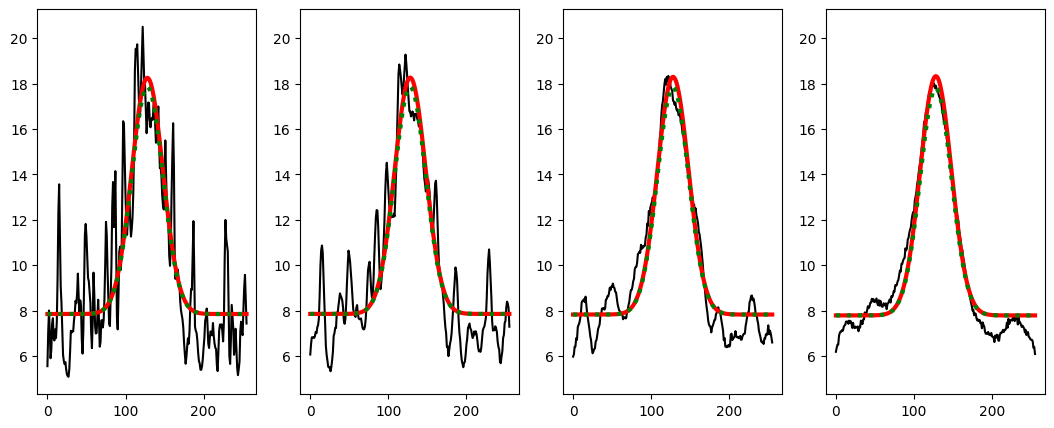

In [21]:
shape = 256
galaxy_width = 20
galaxy_flux = 10
noise_level = 0.1
star_lum_beta = 3
const_bkg_level = 5
Nstars = 500

galaxy = gaussian(pixels, shape/2, galaxy_width, galaxy_flux)
true_flux = galaxy.sum()

# add some stars
star_fluxes = np.random.exponential(star_lum_beta,Nstars)
star_locs = np.random.uniform(0,shape,Nstars)
stars = np.array([gaussian(pixels, loc, star_raw_FWHM, flux) for loc,flux in zip(star_locs,star_fluxes)])

backgrounds = []
fig,axes = plt.subplots(1,4,figsize=(13,5))
for FWHM,ax in zip([1,2,5,10],axes):
    kernel = Gaussian1DKernel(FWHM)

    # add Gaussian noise in each pixel
    noise = np.random.normal(0, noise_level, shape)

    # convolve stars with Gaussian kernel and project everything onto the same axis
    background = noise + convolve(stars.sum(axis=0),kernel=kernel)
    background += const_bkg_level
    bkg_mean = background.mean()
    bkg_std = background.std()
    backgrounds.append(background)
    
    # fit Gaussian to the galaxy
    fixed_gaussian = lambda x,A: gaussian(x,shape/2,galaxy_width,A)
    popt, pcov = curve_fit(fixed_gaussian, pixels, galaxy+background-bkg_mean, p0=[10])
    unc = np.sqrt(np.diag(pcov))[0]
    bestfit_galaxy = fixed_gaussian(pixels, *popt)
    bestfit_flux = bestfit_galaxy.sum()
    print(f'FWHM={FWHM}: true flux = {true_flux:.2f}, fitted flux = {bestfit_flux:.2f}, background mean = {bkg_mean:.2f}')
    ax.plot(galaxy+background,c='k')
    ax.plot(bestfit_galaxy + bkg_mean,c='r',lw=3)
    ax.plot(galaxy + bkg_mean,c='g',lw=3,ls=':')
    
for ax in axes[1:]:
    ax.set_ylim(axes[0].get_ylim())
# plt.ylim(0,)

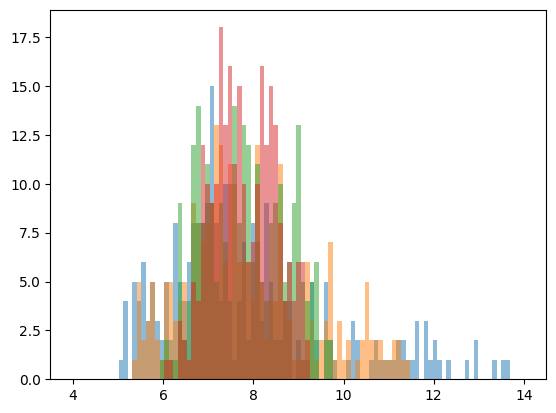

In [23]:
bins = np.linspace(4,14,100)

for bkgs in backgrounds:
    plt.hist(bkgs,bins=bins,alpha=0.5);

In [540]:
1/16

0.0625

In [539]:
(unc_maxes/abs(delta_maxes)).mean()

3.4665320131010873

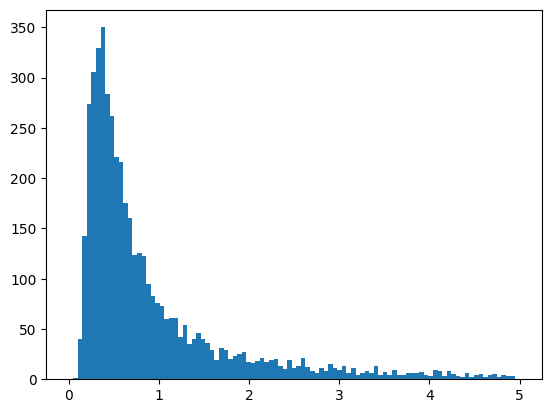

In [542]:
plt.hist(np.sqrt(unc_maxes**2 + unc_bkg_means**2)/abs(delta_maxes),bins=np.linspace(0,5,100));

In [536]:
delta_maxes = fitted_maxes - galaxy_fluxes
unc_bkg_means = bkg_stds/np.sqrt(shape)

delta_maxes.std(),bkg_stds.mean(),np.sqrt(unc_maxes**2 + unc_bkg_means**2).mean()

(4.213239179888938, 7.1985224388460916, 1.6605879767459)

Text(0.5, 0, 'Pixel')

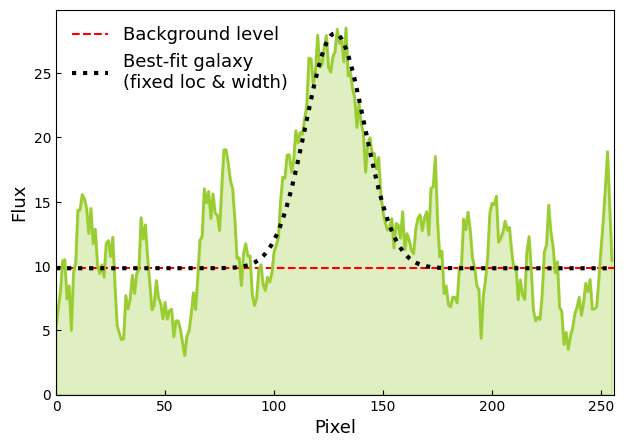

In [521]:
# create a galaxy
galaxy = gaussian(pixels, shape/2, galaxy_width, 20)
true_flux = galaxy.sum()

# add Gaussian noise in each pixel
noise = np.random.normal(0, 1, shape)

# add some stars
Nstars = 1000
star_fluxes = np.random.exponential(5,Nstars)
star_locs = np.random.uniform(0,shape,Nstars)
stars = np.array([gaussian(pixels, loc, star_raw_FWHM, flux) for loc,flux in zip(star_locs,star_fluxes)])

# convolve stars with Gaussian kernel and project everything onto the same axis
background = noise + convolve(stars.sum(axis=0),kernel=kernel)
bkg_mean = background.mean()
bkg_std = background.std()

# fit Gaussian to the galaxy
fixed_gaussian = lambda x,A: gaussian(x,shape/2,galaxy_width,A)
popt, pcov = curve_fit(fixed_gaussian, pixels, galaxy+background-bkg_mean, p0=[10])
bestfit_galaxy = fixed_gaussian(pixels, *popt)
bestfit_flux = bestfit_galaxy.sum()

plt.figure(figsize=(7.2,5))
plt.axhline(bkg_mean,c='r',ls='--',label='Background level')
plt.plot(galaxy+background,c='yellowgreen',lw=2)
plt.fill_between(pixels,0,galaxy+background,color='yellowgreen',alpha=0.3,lw=2)
plt.plot(pixels,bestfit_galaxy+bkg_mean,c='k',lw=3,ls=':',label='Best-fit galaxy\n(fixed loc & width)')
plt.ylim(0,)
plt.xlim(0,images.shape[1])
plt.legend(frameon=False,fontsize=13,loc='upper left')
plt.ylabel('Flux',fontsize=13)
plt.gca().tick_params(direction='in')
plt.xlabel('Pixel',fontsize=13)

In [ ]:
delta_maxes

(-10.0, -2.0)

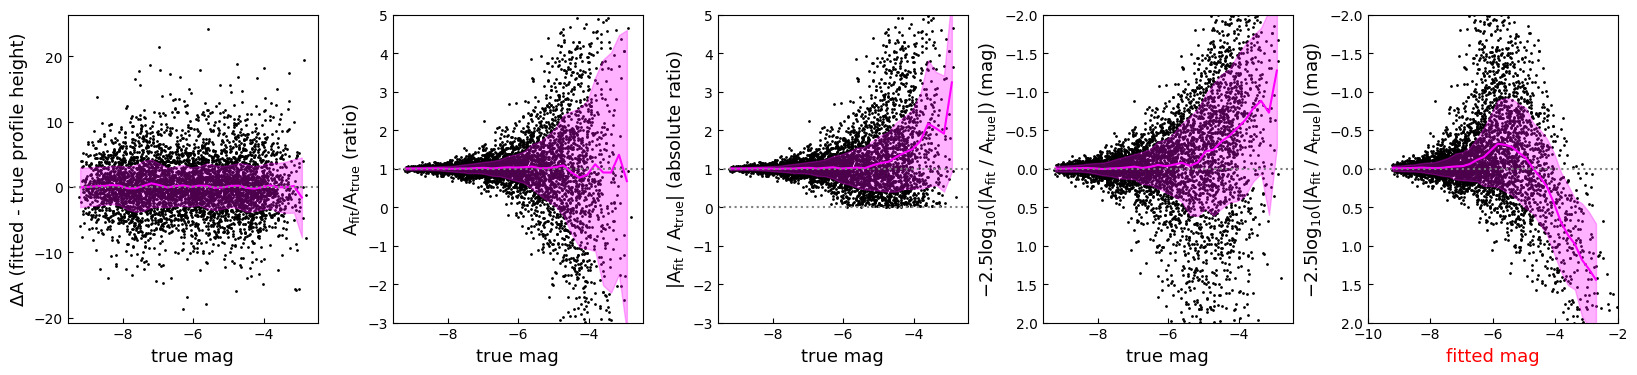

In [442]:
mag_fitted = -2.5*np.log10(fitted_fluxes)
mag_true = -2.5*np.log10(true_fluxes)
delta_mag = mag_fitted - mag_true
delta_maxes = fitted_maxes - galaxy_fluxes
ratio_maxes = fitted_maxes / galaxy_fluxes
abs_ratio_maxes = np.abs(fitted_maxes) / galaxy_fluxes
log_abs_ratio_maxes = -2.5*np.log10(abs_ratio_maxes)

xdata = mag_true
fig,axes = plt.subplots(1,5,figsize=(20,4))
plt.subplots_adjust(wspace=0.3)
eval_locs = np.linspace(-11,0)
xdatas = [mag_true,mag_true,mag_true,mag_true,mag_fitted]
ydatas = [delta_maxes,ratio_maxes,abs_ratio_maxes,log_abs_ratio_maxes,log_abs_ratio_maxes]
for ax,xdata,ydata in zip(axes,xdatas,ydatas):
    means,stds = rolling_stats(eval_locs,0.5,xdata,ydata,
                               min_data_size=30,sigma_clip=2.5)
    ax.scatter(xdata,ydata,s=1,c='k')
    ax.plot(eval_locs,means,c='magenta')
    ax.fill_between(eval_locs,means-stds,means+stds,alpha=0.3,color='magenta')
    ax.set_xlabel('true mag',fontsize=13)
    ax.tick_params(direction='in')
    
axes[4].set_xlabel('fitted mag',fontsize=13,color='r')
axes[0].axhline(0,c='gray',ls=':')
axes[1].axhline(1,c='gray',ls=':')
axes[2].axhline(1,c='gray',ls=':')
axes[2].axhline(0,c='gray',ls=':')
axes[3].axhline(0,c='gray',ls=':')
axes[4].axhline(0,c='gray',ls=':')

axes[0].set_ylabel('ΔA (fitted - true profile height)',fontsize=13)
axes[1].set_ylabel(r'A$_\mathrm{fit}$/A$_\mathrm{true}$ (ratio)',fontsize=13)
axes[2].set_ylabel(r'|A$_\mathrm{fit}$ / A$_\mathrm{true}$| (absolute ratio)',fontsize=13)
axes[3].set_ylabel(r'$-2.5$log$_{10}$(|A$_\mathrm{fit}$ / A$_\mathrm{true}$|) (mag)',fontsize=13)
axes[4].set_ylabel(r'$-2.5$log$_{10}$(|A$_\mathrm{fit}$ / A$_\mathrm{true}$|) (mag)',fontsize=13)

axes[1].set_ylim(-3,5)
axes[2].set_ylim(-3,5)
axes[3].set_ylim(2,-2)
axes[4].set_ylim(2,-2)
axes[4].set_xlim(-10,-2)

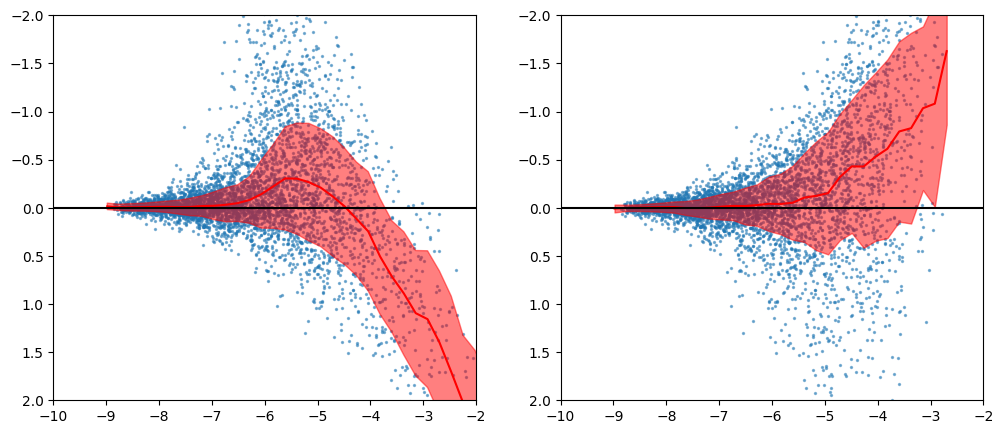

In [385]:
from warnings import filterwarnings
filterwarnings('ignore') # sigma-
mag_fitted = -2.4*np.log10(fitted_fluxes)
mag_true = -2.4*np.log10(true_fluxes)
delta_mag = mag_fitted - mag_true

fig,axes = plt.subplots(1,2,figsize=(12,5))
eval_locs = np.linspace(-11,0)

for ax,xdata in zip(axes,[mag_fitted,mag_true]):
    means,stds = rolling_stats(eval_locs,0.5,xdata,delta_mag,sigma_clip=2.5)
    ax.scatter(xdata,delta_mag,s=2,alpha=0.5)
    ax.plot(eval_locs,means,c='r')
    ax.fill_between(eval_locs,means-stds,means+stds,color='r',alpha=0.5)
    ax.axhline(0,color='k')
    ax.set_xlim(-10,-2)
    ax.set_ylim(2,-2)

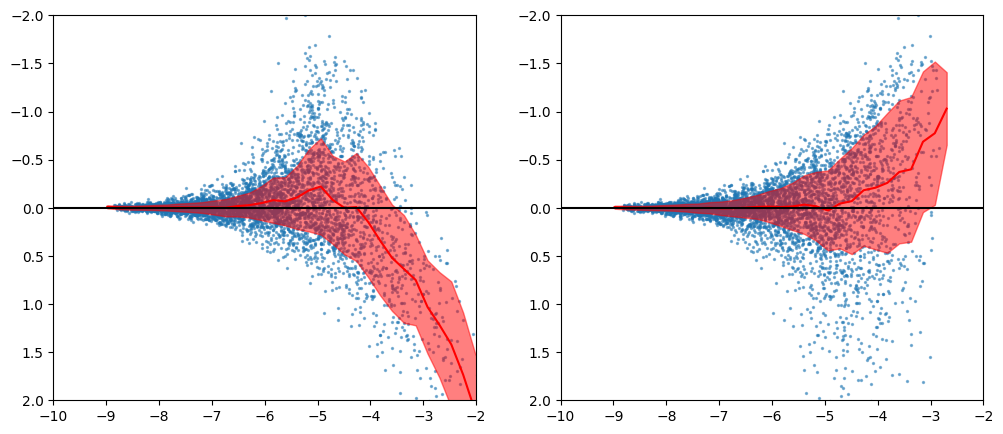

In [371]:
from warnings import filterwarnings
filterwarnings('ignore') # sigma-
mag_fitted = -2.4*np.log10(fitted_fluxes)
mag_true = -2.4*np.log10(true_fluxes)
delta_mag = mag_fitted - mag_true

fig,axes = plt.subplots(1,2,figsize=(12,5))
eval_locs = np.linspace(-11,0)

for ax,xdata in zip(axes,[mag_fitted,mag_true]):
    means,stds = rolling_stats(eval_locs,0.5,xdata,delta_mag,sigma_clip=2.5)
    ax.scatter(xdata,delta_mag,s=2,alpha=0.5)
    ax.plot(eval_locs,means,c='r')
    ax.fill_between(eval_locs,means-stds,means+stds,color='r',alpha=0.5)
    ax.axhline(0,color='k')
    ax.set_xlim(-10,-2)
    ax.set_ylim(2,-2)

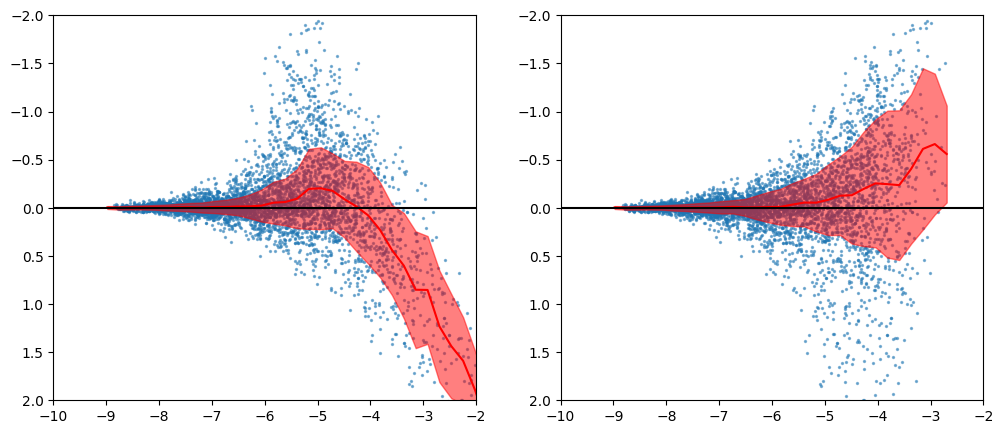

In [368]:
from warnings import filterwarnings
filterwarnings('ignore') # sigma-
mag_fitted = -2.4*np.log10(fitted_fluxes)
mag_true = -2.4*np.log10(true_fluxes)
delta_mag = mag_fitted - mag_true

fig,axes = plt.subplots(1,2,figsize=(12,5))
eval_locs = np.linspace(-11,0)

for ax,xdata in zip(axes,[mag_fitted,mag_true]):
    means,stds = rolling_stats(eval_locs,0.5,xdata,delta_mag,sigma_clip=2.5)
    ax.scatter(xdata,delta_mag,s=2,alpha=0.5)
    ax.plot(eval_locs,means,c='r')
    ax.fill_between(eval_locs,means-stds,means+stds,color='r',alpha=0.5)
    ax.axhline(0,color='k')
    ax.set_xlim(-10,-2)
    ax.set_ylim(2,-2)

/var/folders/hf/dh49zz3n1x5d1p_b4qn8g4z00000gn/T/ipykernel_68221/480331462.py:1: RuntimeWarning: invalid value encountered in log10
  mag_fitted = -2.4*np.log10(fitted_fluxes)


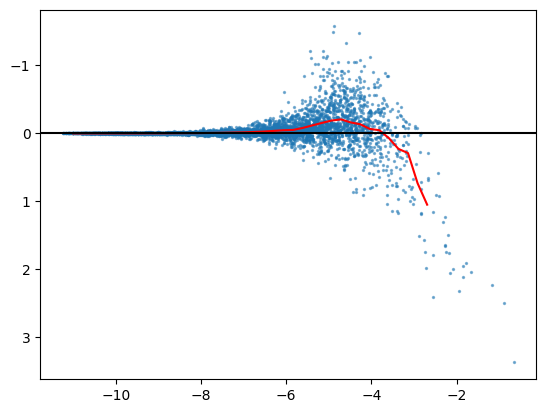

In [182]:
mag_fitted = -2.4*np.log10(fitted_fluxes)
mag_true = -2.4*np.log10(true_fluxes)

means, stds = [],[]
eval_locs = np.linspace(-11,0)
for eval_loc in eval_locs:
    s = (mag_fitted > eval_loc-0.2) & (mag_fitted < eval_loc+0.2)
    if s.sum() > 10:
        means.append(np.mean(mag_fitted[s] - mag_true[s]))
        stds.append(np.std(mag_fitted[s] - mag_true[s]))
    else:
        means.append(np.nan)
        stds.append(np.nan)
        
plt.scatter(mag_fitted,mag_fitted - mag_true,s=2,alpha=0.5)
plt.plot(eval_locs,means,c='r')
plt.gca().invert_yaxis()
plt.axhline(0,color='k')